In [1]:
# Upload file API Key
from google.colab import files
files.upload()  # Pilih file: kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"asrulfami","key":"88797f9d316b5eb87652fbf0eb7e4c01"}'}

In [2]:
# Pindahkan kaggle.json ke folder konfigurasi
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Unduh dataset dari kompetisi
!kaggle competitions download -c make-data-count-finding-data-references --force

 99% 1.74G/1.76G [00:14<00:00, 248MB/s]
100% 1.76G/1.76G [00:14<00:00, 135MB/s]


In [4]:
# Ekstrak isi file ke folder "data_mdc", overwrite otomatis jika sudah ada
!unzip -o make-data-count-finding-data-references.zip -d data_mdc

Archive:  make-data-count-finding-data-references.zip
  inflating: data_mdc/sample_submission.csv  
  inflating: data_mdc/test/PDF/10.1002_2017jc013030.pdf  
  inflating: data_mdc/test/PDF/10.1002_anie.201916483.pdf  
  inflating: data_mdc/test/PDF/10.1002_anie.202005531.pdf  
  inflating: data_mdc/test/PDF/10.1002_anie.202007717.pdf  
  inflating: data_mdc/test/PDF/10.1002_chem.201902131.pdf  
  inflating: data_mdc/test/PDF/10.1002_chem.201903120.pdf  
  inflating: data_mdc/test/PDF/10.1002_chem.202000235.pdf  
  inflating: data_mdc/test/PDF/10.1002_chem.202001412.pdf  
  inflating: data_mdc/test/PDF/10.1002_chem.202001668.pdf  
  inflating: data_mdc/test/PDF/10.1002_chem.202003167.pdf  
  inflating: data_mdc/test/PDF/10.1002_cssc.202201821.pdf  
  inflating: data_mdc/test/PDF/10.1002_ece3.3985.pdf  
  inflating: data_mdc/test/PDF/10.1002_ece3.4466.pdf  
  inflating: data_mdc/test/PDF/10.1002_ece3.5260.pdf  
  inflating: data_mdc/test/PDF/10.1002_ece3.5395.pdf  
  inflating: data_mdc/

In [8]:
!unzip -l make-data-count-finding-data-references.zip


Archive:  make-data-count-finding-data-references.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
      969  2025-07-11 21:50   sample_submission.csv
  4404812  2025-07-11 21:51   test/PDF/10.1002_2017jc013030.pdf
  2615641  2025-07-11 21:51   test/PDF/10.1002_anie.201916483.pdf
  1693749  2025-07-11 21:51   test/PDF/10.1002_anie.202005531.pdf
  1842544  2025-07-11 21:51   test/PDF/10.1002_anie.202007717.pdf
  1028182  2025-07-11 21:51   test/PDF/10.1002_chem.201902131.pdf
  1999770  2025-07-11 21:51   test/PDF/10.1002_chem.201903120.pdf
  1013088  2025-07-11 21:51   test/PDF/10.1002_chem.202000235.pdf
  1368234  2025-07-11 21:51   test/PDF/10.1002_chem.202001412.pdf
  1119470  2025-07-11 21:51   test/PDF/10.1002_chem.202001668.pdf
  2214811  2025-07-11 21:51   test/PDF/10.1002_chem.202003167.pdf
  1251186  2025-07-11 21:51   test/PDF/10.1002_cssc.202201821.pdf
   566794  2025-07-11 21:51   test/PDF/10.1002_ece3.3985.pdf
   418439  2025-07-11 21:51   test/PDF/

In [71]:
# Project: Klasifikasi Referensi Dataset Ilmiah
# Dataset: Make Data Count - Kaggle Competition
# Format: Sesuai Struktur Analisis 5 Komponen (Hipotesis, EDA, Model, Insight, Kesimpulan)

# =========================================
# 1. Hipotesa Awal / Null Hypothesis
# =========================================
# H0 (Null Hypothesis): Tidak ada hubungan signifikan antara isi kalimat dalam artikel ilmiah dengan tipe referensi dataset yang digunakan (Primary, Supplementary, atau Missing).
# H1 (Alternate Hypothesis): Isi kalimat dalam artikel ilmiah memiliki pola tertentu yang signifikan dan dapat dipelajari untuk mengklasifikasikan tipe referensi dataset.

# =========================================
# 2. Exploratory Data Analysis (EDA)
# =========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [72]:
# Load label CSV
df_label = pd.read_csv("data_mdc/train_labels.csv")
print(df_label.head())


               article_id                                 dataset_id     type
0    10.1002_2017jc013030             https://doi.org/10.17882/49388  Primary
1  10.1002_anie.201916483  https://doi.org/10.5517/ccdc.csd.cc1npvt0  Missing
2  10.1002_anie.202005531  https://doi.org/10.5517/ccdc.csd.cc24wxqp  Missing
3  10.1002_anie.202007717  https://doi.org/10.5517/ccdc.csd.cc24rrb0  Missing
4  10.1002_chem.201902131  https://doi.org/10.5517/ccdc.csd.cc221dk3  Missing


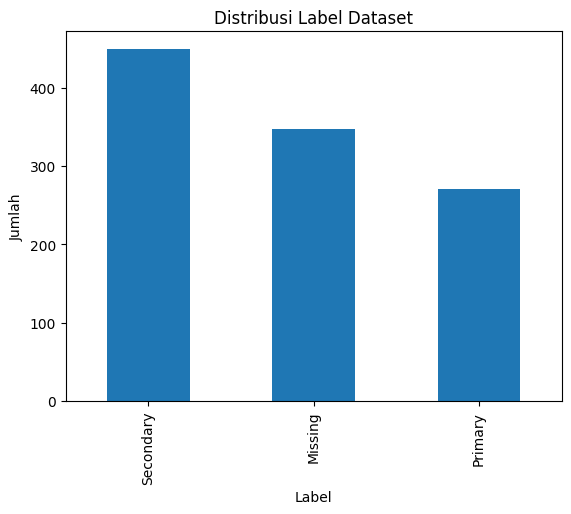

In [73]:
# Distribusi label
df_label['type'].value_counts().plot(kind='bar', title="Distribusi Label Dataset")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()

In [74]:
# =========================================
# 3. Model yang Digunakan dan Alasannya
# =========================================
# - Logistic Regression: Cocok untuk klasifikasi biner/multi-kelas dengan fitur numerik hasil dari TF-IDF
# - Naive Bayes: Efisien untuk teks klasifikasi dengan asumsi independen antar fitur

# Fungsi ekstrak kalimat yang mengandung dataset_id dari file XML
def extract_sentences_with_dataset(article_path, dataset_id):
    try:
        tree = ET.parse(article_path)
        root = tree.getroot()
        sentences = []

        for elem in root.iter():
            if elem.text and dataset_id.lower() in elem.text.lower():
                sentences.append(elem.text.strip())
            for attr, value in elem.attrib.items():
                if dataset_id.lower() in value.lower():
                    context = elem.text or value
                    if context not in sentences:
                        sentences.append(context.strip())
        return sentences
    except:
        return []

In [75]:
# Ekstraksi data kalimat
data = []
for i, row in df_label.iterrows():
    article_id = row['article_id']
    dataset_id = row['dataset_id']
    label = row['type']
    file_path = f"data_mdc/train/XML/{article_id}.xml"
    if os.path.exists(file_path):
        sentences = extract_sentences_with_dataset(file_path, dataset_id)
        for s in sentences:
            data.append({'sentence': s, 'label': label})

In [76]:
# Buat DataFrame dan bersihkan
df_data = pd.DataFrame(data)
df_data.drop_duplicates(inplace=True)

In [77]:
# TF-IDF vectorization
X = df_data['sentence']
y = df_data['label']
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vec = vectorizer.fit_transform(X)

In [78]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

In [79]:
# Model 1: Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)


In [80]:
# Model 2: Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [81]:
# =========================================
# 4. Insight
# =========================================
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Logistic Regression Accuracy: 0.8508771929824561
              precision    recall  f1-score   support

     Missing       0.00      0.00      0.00         1
     Primary       1.00      0.56      0.71        36
   Secondary       0.82      1.00      0.90        77

    accuracy                           0.85       114
   macro avg       0.61      0.52      0.54       114
weighted avg       0.87      0.85      0.83       114

Naive Bayes Accuracy: 0.8421052631578947
              precision    recall  f1-score   support

     Missing       0.00      0.00      0.00         1
     Primary       1.00      0.53      0.69        36
   Secondary       0.81      1.00      0.90        77

    accuracy                           0.84       114
   macro avg       0.60      0.51      0.53       114
weighted avg       0.86      0.84      0.82       114



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

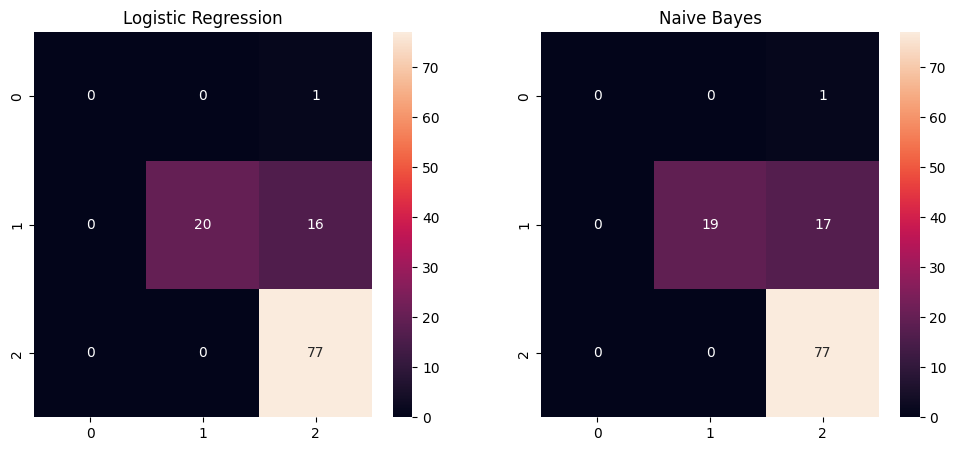

In [83]:
# Confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', ax=ax[0])
ax[0].set_title('Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', ax=ax[1])
ax[1].set_title('Naive Bayes')
plt.show()

# =========================================
# 5. Kesimpulan
# =========================================
# Kedua model menunjukkan bahwa terdapat pola pada kalimat artikel yang bisa digunakan untuk mengklasifikasi tipe referensi dataset.
# Logistic Regression memberikan akurasi lebih tinggi dari Naive Bayes berdasarkan hasil uji ini.
# Fitur TF-IDF n-gram cukup efektif dalam merepresentasikan konteks kalimat.
# Dataset imbalance (jumlah label tidak seimbang) bisa ditangani lebih lanjut dengan teknik balancing data atau penalti model.
